# Data Exploration Notebook
The purpose of this notebook is to explore the dataset in order to gain insights for future model building. It also works up to step 8 in the Supervised ML flow chart.

## Import Packages

In [1]:
import sys
import time
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

## Set up for imports of .py modules

In [2]:
path = Path(os.getcwd())
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/evangelinekim/Developer/Projects/Roux_Institute/DS5220/DS5220-Supervised-ML-Project


## Import Python Modules

In [3]:
import utils.sml_utils as sml_utils

## Parameters

In [4]:
path_to_data = 'data/winequality-white.csv'
target_attr = 'quality'
test_size = 0.20
train_test_split_random_state = 42
missingness_threshold = 0.20

## Set up time

In [5]:
start = time.time()

## Reading in data

In [6]:
df = pd.read_csv(path_to_data, sep=";")
print(df.shape)
df.head()

(4898, 12)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

## 1. Missingness check

This was completed in phase 1!

In [7]:
print(df.shape)
df = df.dropna(subset=target_attr)
print(df.shape)

(4898, 12)
(4898, 12)


## 2. Train/Test Data Split

`wine_train_df` and `wine_test_df` were already created in phase 1! Here, we are making a copy of the data for exploration.

In [8]:
train_df = pd.read_csv('data/wine_train_df.csv').copy() # Make copy so original is not affected
train_cap_x_df = train_df.iloc[:, :-1]  # All columns except the last one
train_y_df = train_df.iloc[:, -1].to_frame()

## 3. Train/Validation Split

This step will be omitted because cross-validation will be used in later steps

## 4. Checking Attributes Types

In [9]:
train_cap_x_df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object

In [10]:
train_cap_x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3918 non-null   float64
 1   volatile acidity      3918 non-null   float64
 2   citric acid           3918 non-null   float64
 3   residual sugar        3918 non-null   float64
 4   chlorides             3918 non-null   float64
 5   free sulfur dioxide   3918 non-null   float64
 6   total sulfur dioxide  3918 non-null   float64
 7   density               3918 non-null   float64
 8   pH                    3918 non-null   float64
 9   sulphates             3918 non-null   float64
 10  alcohol               3918 non-null   float64
dtypes: float64(11)
memory usage: 336.8 KB


In [11]:
train_cap_x_df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    3918.000000       3918.000000  3918.000000     3918.000000   
mean        6.865046          0.279338     0.332731        6.450702   
std         0.844483          0.101606     0.119758        5.139311   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.330000     0.380000       10.000000   
max        11.800000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  3918.000000          3918.000000           3918.000000  3918.000000   
mean      0.045734            35.094564            138.001149     0.994071   
std       0.021797            16.676958             42.067667     0.003022   
min       0.009000             3.000000             10.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991740   
50%       0.043000            33.000000            134.000000     0.993800   
75%       0.050000            46.000000            167.000000     0.996200   
max       0.346000           146.500000            313.000000     1.038980   

                pH    sulphates      alcohol  
count  3918.000000  3918.000000  3918.000000  
mean      3.189293     0.489781    10.508840  
std       0.150183     0.113590     1.227887  
min       2.720000     0.220000     8.000000  
25%       3.090000     0.410000     9.500000  
50%       3.180000     0.470000    10.400000  
75%       3.280000     0.550000    11.400000  
max       3.820000     1.080000    14.200000

### Examining some feature selection configurations (variance threshold, univariate features selection, and recursive feature elimination)

In [12]:
variance_threshold = VarianceThreshold(0.01) # I guess we want attributes with non-zero variance?
variance_threshold.fit(train_cap_x_df)
variances = variance_threshold.variances_
variance_scores = pd.DataFrame({'Attribute': train_cap_x_df.columns, 'Variance': variances}).sort_values(by='Variance', ascending=False)#.to_string(index=False)
print("ATTRIBUTE VARIANCE SCORES:")
print(variance_scores)

ATTRIBUTE VARIANCE SCORES:
               Attribute     Variance
6   total sulfur dioxide  1769.236918
5    free sulfur dioxide   278.049953
3         residual sugar    26.405772
10               alcohol     1.507321
0          fixed acidity     0.712970
8                     pH     0.022549
2            citric acid     0.014338
9              sulphates     0.012899
1       volatile acidity     0.010321
4              chlorides     0.000475
7                density     0.000009


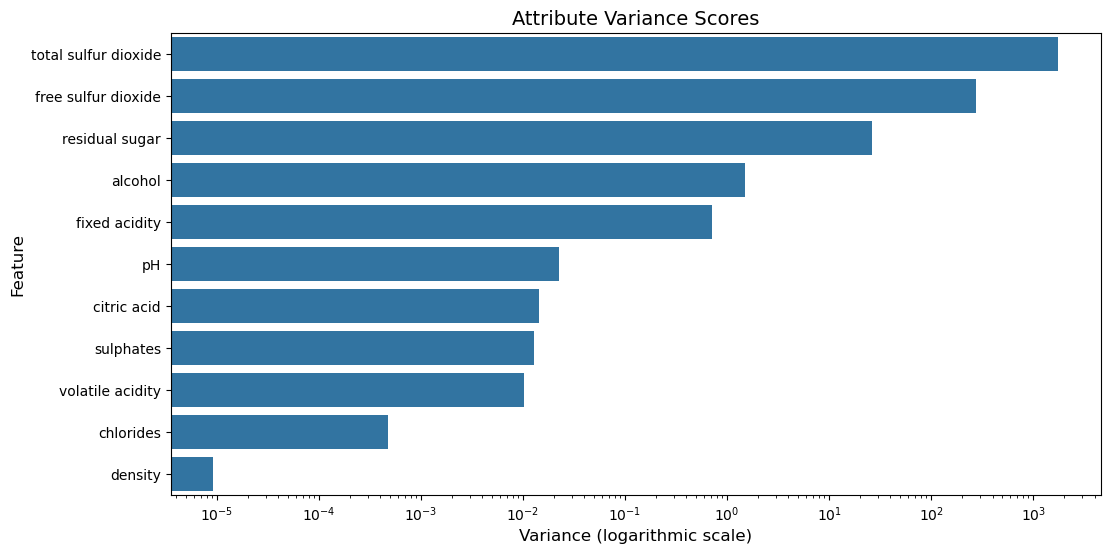

In [13]:
# Plotting the variance scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Variance', y='Attribute', data=variance_scores)
plt.title('Attribute Variance Scores', fontsize=14)
plt.xlabel('Variance (logarithmic scale)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xscale('log') ## Plotting this by log for better readability
plt.show()

In [14]:
# Univariate Feature Selection Scores. Using f_regression because this part is more exploratory than anything...
selector = SelectKBest(score_func=f_regression, k='all')
X_new = selector.fit_transform(train_cap_x_df, train_y_df['quality'])
scores = selector.scores_
feature_scores = pd.DataFrame({'Attribute': train_cap_x_df.columns, 'Score': scores}).sort_values(by='Score', ascending=False)#.to_string(index=False)
print("ATTRIBUTE SCORES VIA UNIVARIATE FEATURE SELECTION:")
print(feature_scores)

ATTRIBUTE SCORES VIA UNIVARIATE FEATURE SELECTION:
               Attribute       Score
10               alcohol  896.871903
7                density  388.880430
1       volatile acidity  170.490487
4              chlorides  161.756748
6   total sulfur dioxide  106.233764
0          fixed acidity   55.290669
8                     pH   42.123493
3         residual sugar   37.082675
9              sulphates   15.115154
5    free sulfur dioxide    3.253095
2            citric acid    0.770059


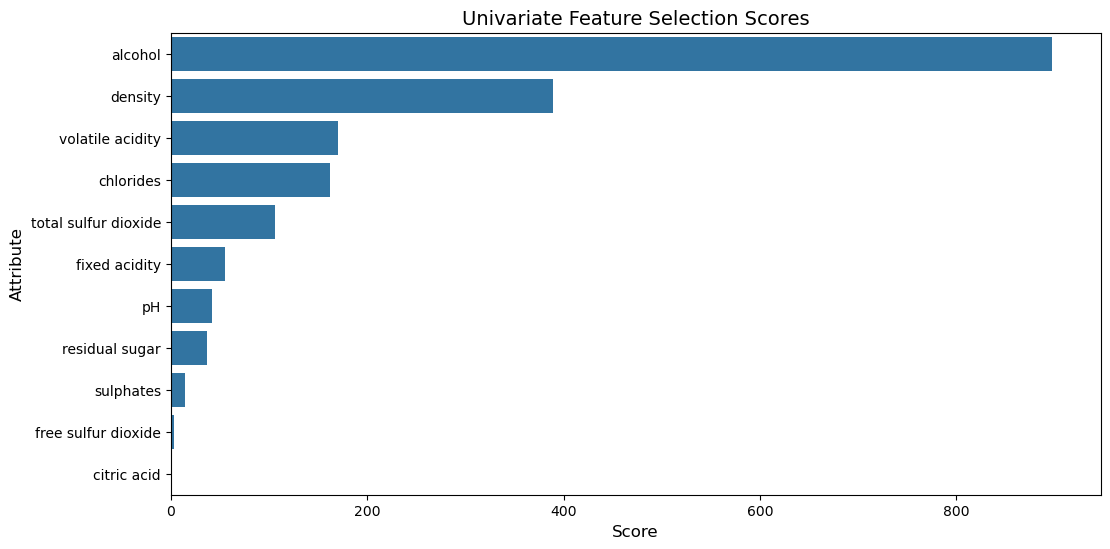

In [15]:
# Plotting the feature scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Attribute', data=feature_scores)
plt.title('Univariate Feature Selection Scores', fontsize=14)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Attribute', fontsize=12)
plt.xlim(0, feature_scores['Score'].max() + 50)  # Adjusting the x-axis limit for better readability
plt.show()

In [16]:
# Recursive Feature Elimination Ranks.
# Please note the lack of cross validation and how this only runs reliably with linear data.
# It is highly model dependent and was mostly used for a simple observational support for future decisions!
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=1)
rfe.fit(train_cap_x_df, train_y_df['quality'])
ranking = rfe.ranking_
feature_ranking = pd.DataFrame({'Rank': ranking, 'Attribute': train_cap_x_df.columns}).sort_values(by='Rank').to_string(index=False)
print("ATTRIBUTE RANKS VIA RECURSIVE FEATURE ELIMINATION:")
print(feature_ranking)


ATTRIBUTE RANKS VIA RECURSIVE FEATURE ELIMINATION:
 Rank            Attribute
    1              density
    2            chlorides
    3     volatile acidity
    4            sulphates
    5              alcohol
    6                   pH
    7       residual sugar
    8        fixed acidity
    9          citric acid
   10  free sulfur dioxide
   11 total sulfur dioxide


### More Visualizations

<Figure size 1200x800 with 0 Axes>

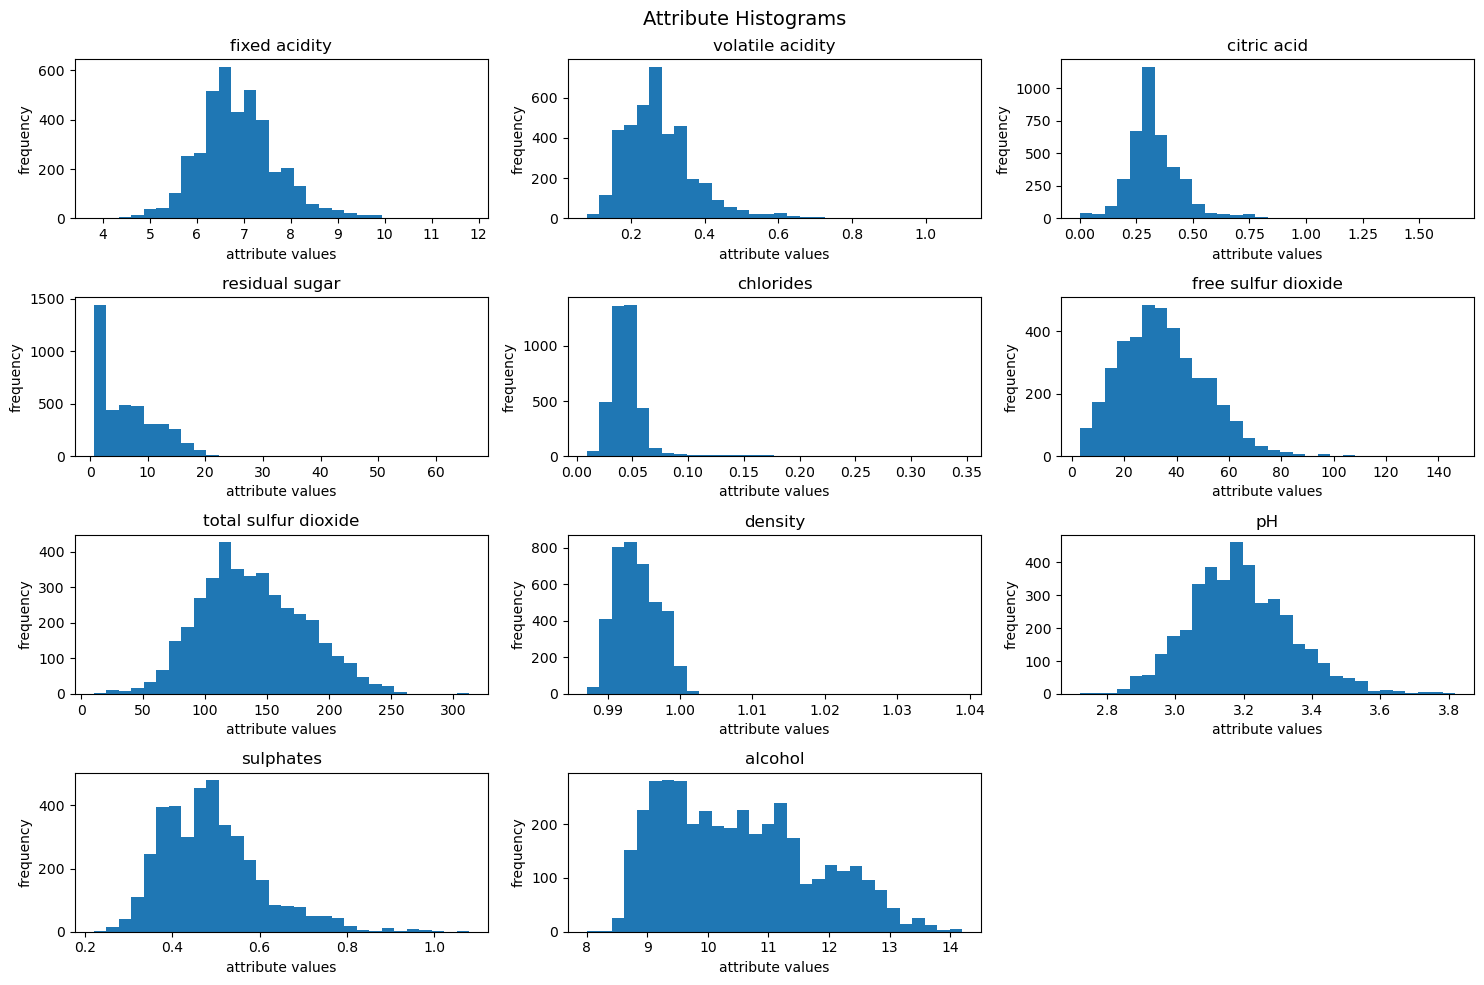

In [17]:
## Histograms for all the attributes
plt.figure(figsize=(12, 8))
axes = train_cap_x_df.hist(bins=30, figsize=(15, 10), grid=False)
plt.suptitle("Attribute Histograms", fontsize=14)
for ax in axes.flatten():
    ax.set_xlabel("attribute values")
    ax.set_ylabel("frequency")
plt.tight_layout()  
plt.show()


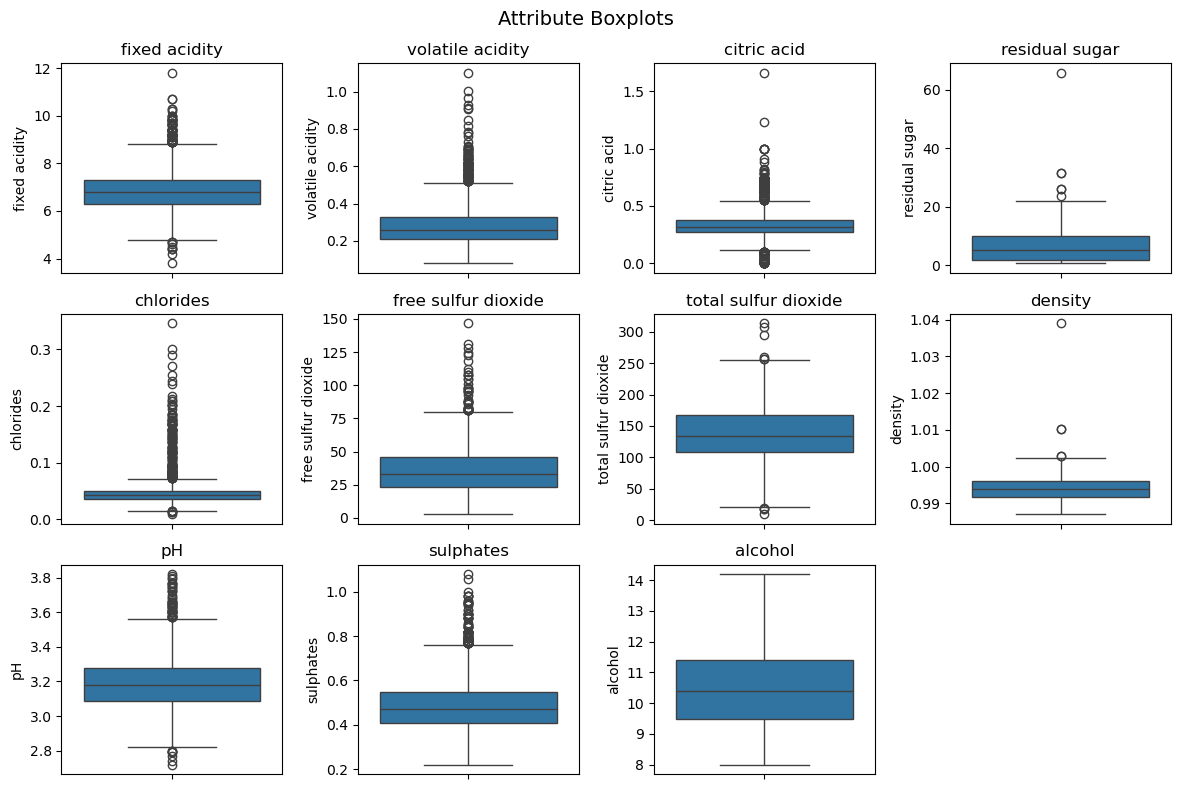

In [18]:
## Box plots for all the attributes
plt.figure(figsize=(12, 8))
for index, column in enumerate(train_cap_x_df.columns, 1):
    plt.subplot(3, 4, index)
    sns.boxplot(y=train_cap_x_df[column])
    plt.title(column)
plt.suptitle("Attribute Boxplots", fontsize=14)
plt.tight_layout()

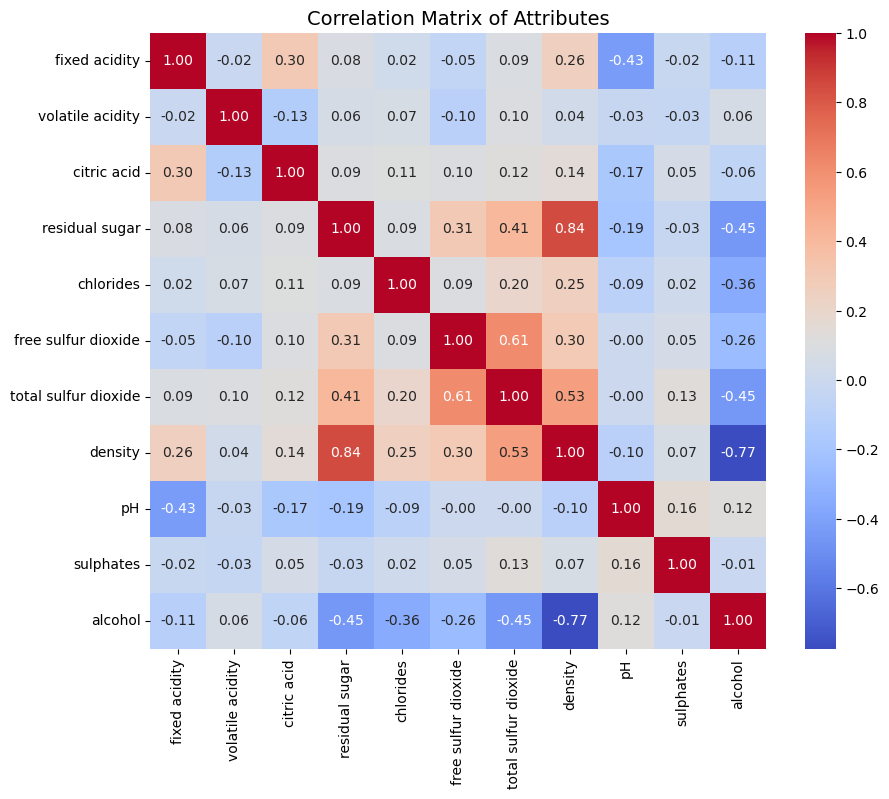

In [19]:
## Attribute correlation matrix
corr_matrix_attr = train_cap_x_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_attr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Attributes", fontsize=14)
plt.show()

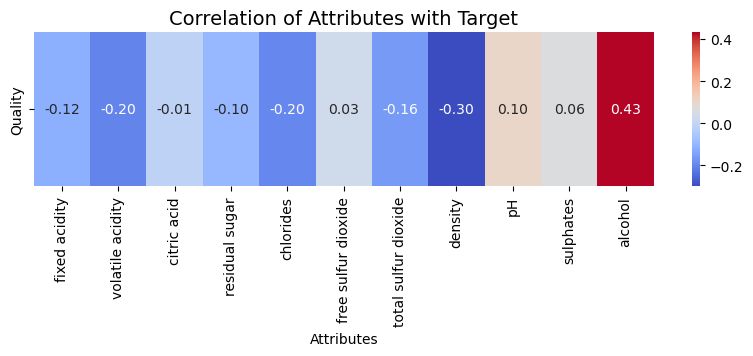

In [20]:
target_correlation = train_cap_x_df.corrwith(train_y_df['quality'])
target_correlation_fixed = target_correlation.values.reshape(1, -1) # Reshaping for heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(target_correlation_fixed, annot=True, fmt='.2f', cmap='coolwarm', 
            yticklabels=['Quality'], xticklabels=target_correlation.index)
plt.title("Correlation of Attributes with Target", fontsize=14)
plt.xlabel("Attributes")
plt.show()

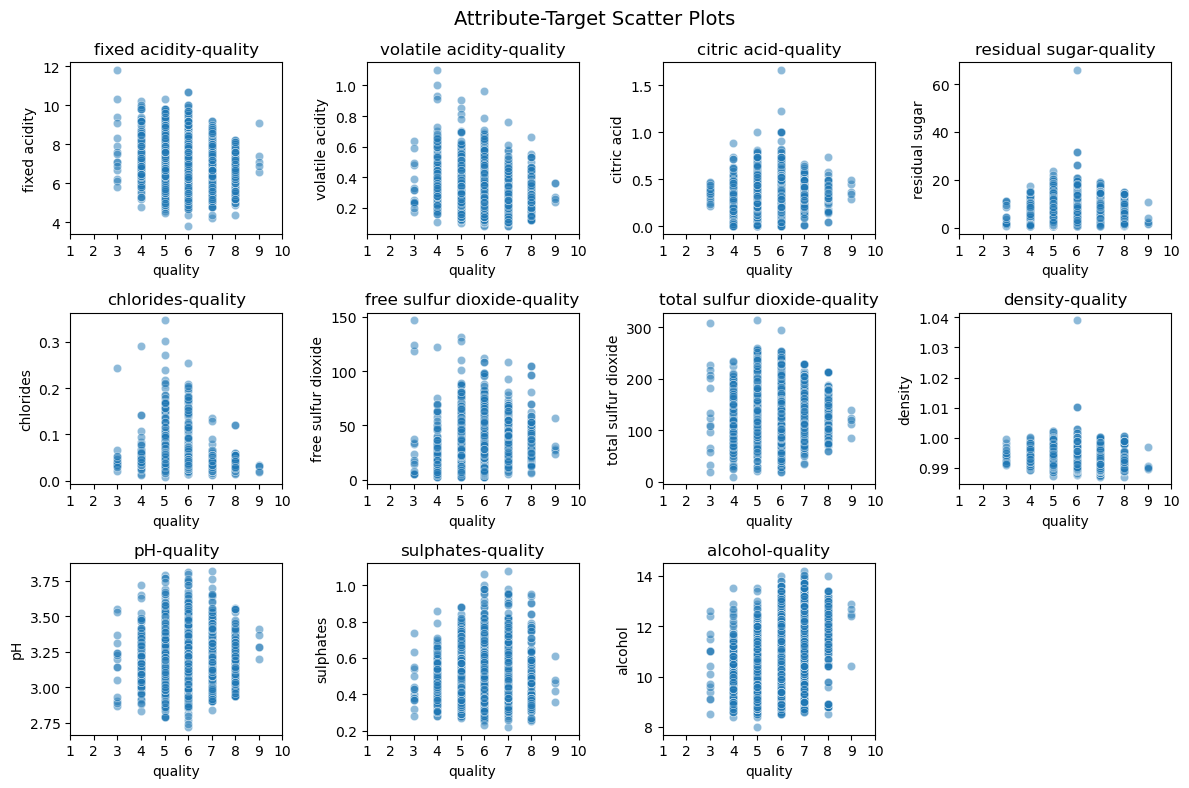

In [21]:
# Attribute-Target Scatter plots
plt.figure(figsize=(12, 8))
for i, col in enumerate(train_cap_x_df, 1):
    plt.subplot(3, 4, i)
    sns.scatterplot(y=train_df[col], x=train_df['quality'], alpha=0.5)
    plt.xticks(range(1, 11))
    plt.title(f"{col}-quality")
plt.suptitle("Attribute-Target Scatter Plots", fontsize=14)
plt.tight_layout()

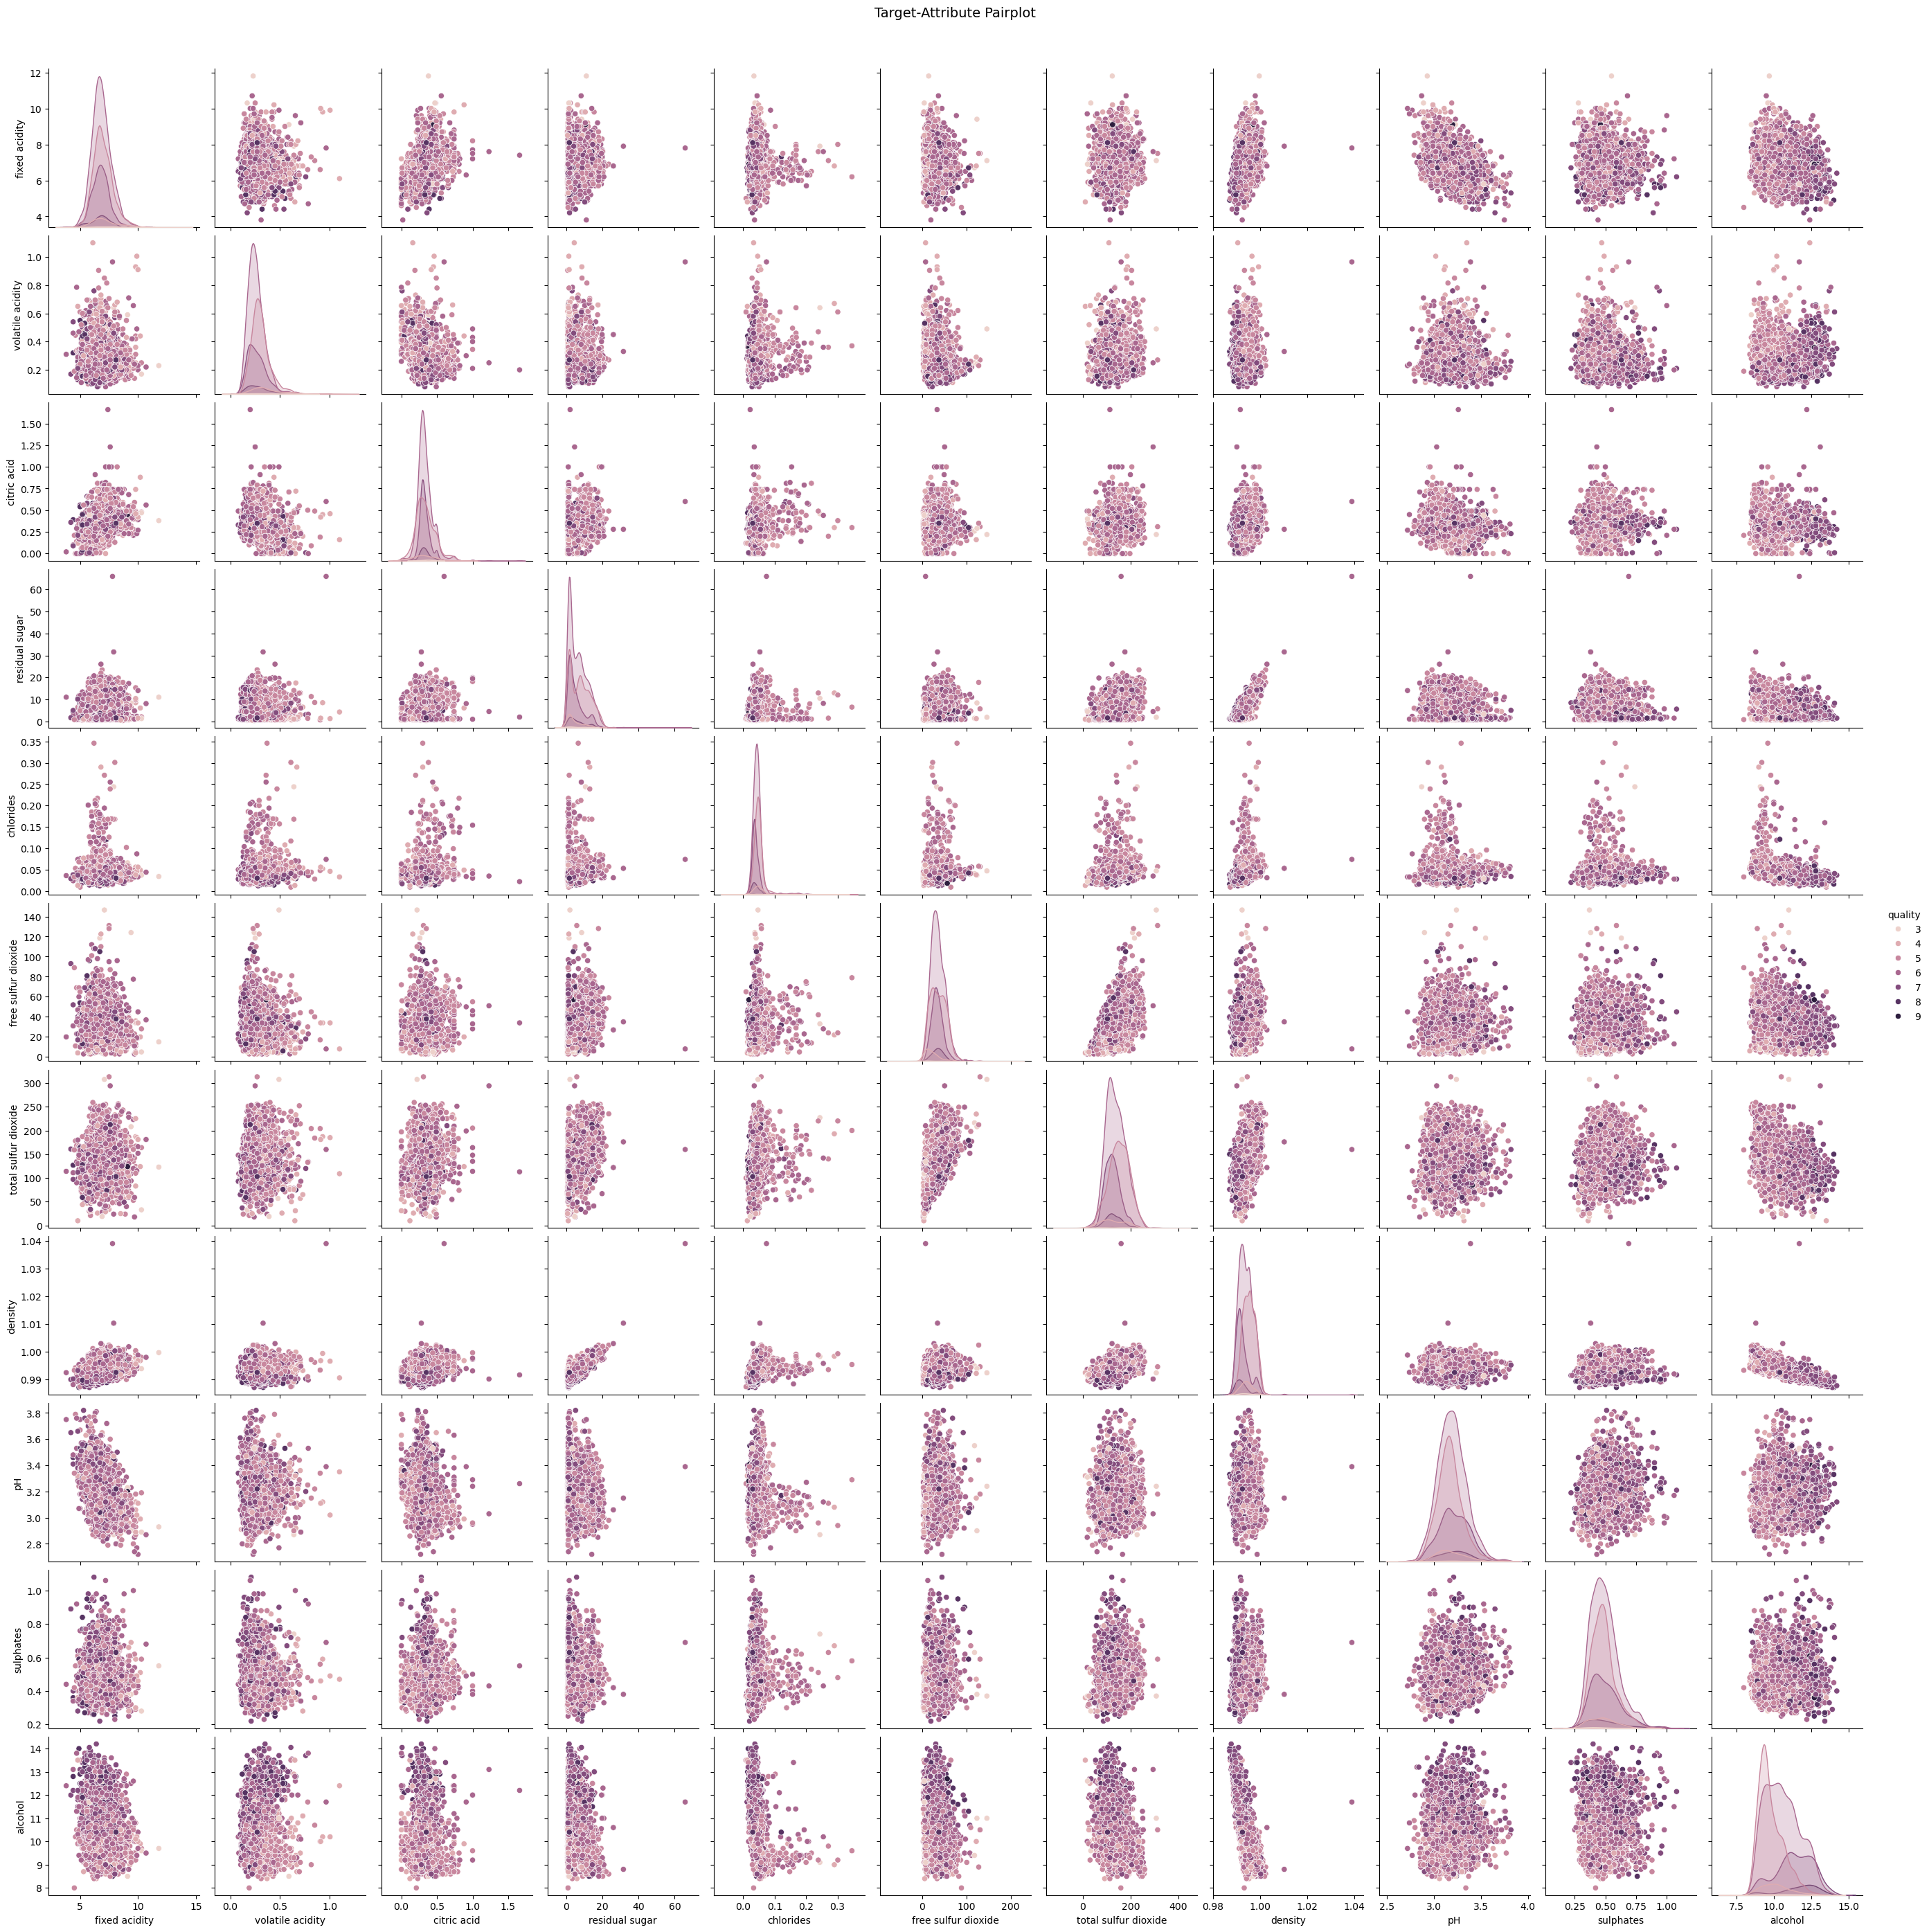

In [22]:
## Attribute-Target Pairplot
sns.pairplot(train_df, hue='quality')
plt.suptitle("Target-Attribute Pairplot", y=1.02, fontsize=14)
plt.show()

## 5. Handle Missing Values

In [23]:
train_df.isna().sum() # There are no missing values in the data set.

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [24]:
return_dict = sml_utils.get_missingness(train_cap_x_df, missingness_threshold)
missingness_drop_list = return_dict['missingness_drop_list']

fixed acidity missingness = 0.0
volatile acidity missingness = 0.0
citric acid missingness = 0.0
residual sugar missingness = 0.0
chlorides missingness = 0.0
free sulfur dioxide missingness = 0.0
total sulfur dioxide missingness = 0.0
density missingness = 0.0
pH missingness = 0.0
sulphates missingness = 0.0
alcohol missingness = 0.0

missingness_drop_list:
[]


## 6. Exclude non-ML Attributes

In [25]:
train_cap_x_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [26]:
non_ml_attr_list = [] # no non-machine learning attributes were identified

## 7. Remove Unwanted Attributes

In [27]:
train_cap_x_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [28]:
ml_attr_drop_list = []

## 8. ML Attribute Configuration

In [29]:
ml_ignore_list = missingness_drop_list + non_ml_attr_list + ml_attr_drop_list
ml_ignore_list

[]

In [30]:
# All of the attributes in this data set are continuous and numerical
numerical_attr = list(train_cap_x_df.columns)

# There were no nominal attributes found in this data set.
# They are all continuous numerical values from a series of physicochemical tests.
nominal_attr = []

assert(train_cap_x_df.shape[1] == len(ml_ignore_list) + len(nominal_attr) + len(numerical_attr))

print(f'ml_ignore_list: {ml_ignore_list}')
print(f'\nnumerical_attr: {numerical_attr}')
print(f'nominal_attr: {nominal_attr}')
print(f'\nnumber of machine learning attributes: {len(numerical_attr) + len(nominal_attr)}')
print(f'\nnumerical_attr and nominal_attr: {numerical_attr + nominal_attr}')

ml_ignore_list: []

numerical_attr: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
nominal_attr: []

number of machine learning attributes: 11

numerical_attr and nominal_attr: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Script Runtime

In [31]:
end = time.time()
runtime = (end - start) / 60
print(f'Script runtime: {runtime:.4f} minutes')

Script runtime: 0.4024 minutes
